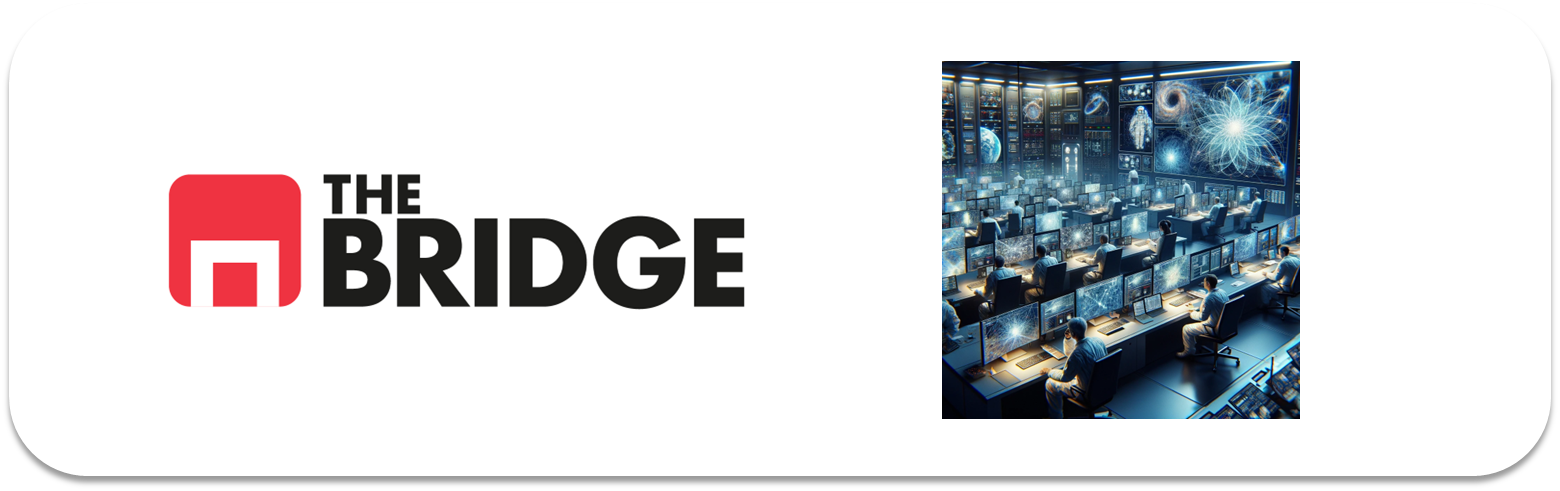

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [59]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



Cargando datos de entrenamiento...
Cargando datos de prueba...
Datos de entrenamiento: (4000, 32, 32, 3), (4000,)
Datos de prueba: (1000, 32, 32, 3), (1000,)


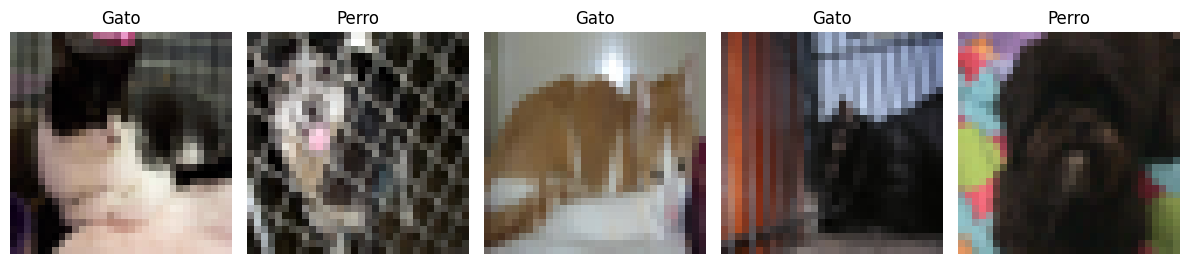

In [36]:
# Definir rutas de los directorios
train_dirs = ['./data/github_train_0', './data/github_train_1', './data/github_train_2', './data/github_train_3']
test_dir = './data/github_test'

def extract_label_from_filename(filename):
    """Extrae la etiqueta (perro o gato) del nombre del archivo"""
    if 'dog' in filename.lower():
        return 1  # Perro
    elif 'cat' in filename.lower():
        return 0  # Gato
    else:
        raise ValueError(f"No se puede determinar la clase desde el nombre: {filename}")

def load_and_preprocess_images(directory_list, target_size=(32, 32)):
    """
    Carga y preprocesa imágenes desde uno o varios directorios
    
    Args:
        directory_list: Lista de directorios o un solo directorio
        target_size: Tamaño objetivo para redimensionar las imágenes
        
    Returns:
        X: Array de imágenes preprocesadas
        y: Array de etiquetas
    """
    if isinstance(directory_list, str):
        directory_list = [directory_list]
    
    images = []
    labels = []
    filenames = []
    
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                # Ruta completa del archivo
                img_path = os.path.join(directory, filename)
                
                try:
                    # Cargar y redimensionar la imagen
                    img = Image.open(img_path)
                    img = img.resize(target_size)
                    img = img.convert('RGB')  # Aseguramos que todas las imágenes estén en RGB
                    
                    # Convertir la imagen a un array y normalizar
                    img_array = np.array(img) / 255.0
                    
                    # Extraer la etiqueta del nombre del archivo
                    label = extract_label_from_filename(filename)
                    
                    images.append(img_array)
                    labels.append(label)
                    filenames.append(filename)
                except Exception as e:
                    print(f"Error al procesar {img_path}: {e}")
    
    return np.array(images), np.array(labels), filenames

# Cargar datos de entrenamiento
print("Cargando datos de entrenamiento...")
X_train, y_train, _ = load_and_preprocess_images(train_dirs)

# Cargar datos de prueba
print("Cargando datos de prueba...")
X_test, y_test, test_filenames = load_and_preprocess_images(test_dir)

print(f"Datos de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Datos de prueba: {X_test.shape}, {y_test.shape}")

# Visualizar algunas imágenes de entrenamiento
def plot_images(X, y, n=5):
    """Visualiza n imágenes aleatorias con sus etiquetas"""
    plt.figure(figsize=(12, 3))
    indices = np.random.choice(len(X), n, replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(1, n, i+1)
        plt.imshow(X[idx])
        plt.title("Perro" if y[idx] == 1 else "Gato")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()



plot_images(X_train, y_train)

In [37]:
X_train

array([[[[0.48627451, 0.38431373, 0.24705882],
         [0.44705882, 0.34901961, 0.2       ],
         [0.58039216, 0.48235294, 0.32156863],
         ...,
         [0.36078431, 0.27058824, 0.18431373],
         [0.49411765, 0.27058824, 0.17647059],
         [0.43921569, 0.23529412, 0.14509804]],

        [[0.40392157, 0.32156863, 0.2       ],
         [0.41568627, 0.33333333, 0.20392157],
         [0.49411765, 0.41568627, 0.27058824],
         ...,
         [0.44705882, 0.23921569, 0.16862745],
         [0.48627451, 0.28627451, 0.17647059],
         [0.43921569, 0.22352941, 0.13333333]],

        [[0.45490196, 0.35686275, 0.22745098],
         [0.45098039, 0.35686275, 0.21568627],
         [0.55294118, 0.4627451 , 0.30588235],
         ...,
         [0.37254902, 0.16470588, 0.10980392],
         [0.34901961, 0.18823529, 0.12156863],
         [0.40392157, 0.21568627, 0.11372549]],

        ...,

        [[0.11764706, 0.11764706, 0.09411765],
         [0.27058824, 0.25882353, 0.21960784]

In [38]:
y_train_df = pd.DataFrame(y_train, columns=['label'])

In [39]:
# Para X_train es más complejo porque son imágenes
# Primero aplanar cada imagen
X_flattened = X_train.reshape(X_train.shape[0], -1)  # Aplana cada imagen 32x32x3 a un vector
X_train_df = pd.DataFrame(X_flattened)

In [40]:
X_flattened

array([[0.48627451, 0.38431373, 0.24705882, ..., 0.37647059, 0.33333333,
        0.22745098],
       [0.84705882, 0.16862745, 0.30980392, ..., 0.83137255, 0.08235294,
        0.21960784],
       [0.82352941, 0.69411765, 0.61960784, ..., 0.2745098 , 0.18431373,
        0.10980392],
       ...,
       [0.90588235, 0.77254902, 0.62352941, ..., 0.56862745, 0.6627451 ,
        0.71372549],
       [1.        , 0.96862745, 0.97254902, ..., 0.49411765, 0.45490196,
        0.44705882],
       [0.97254902, 0.95294118, 0.91764706, ..., 0.99607843, 0.99607843,
        0.99607843]])

In [41]:
y_train_df

,label
0,0
1,0
2,0
3,0
4,0
...,...
3995,1
3996,1
3997,1
3998,1


In [42]:
X_train

array([[[[0.48627451, 0.38431373, 0.24705882],
         [0.44705882, 0.34901961, 0.2       ],
         [0.58039216, 0.48235294, 0.32156863],
         ...,
         [0.36078431, 0.27058824, 0.18431373],
         [0.49411765, 0.27058824, 0.17647059],
         [0.43921569, 0.23529412, 0.14509804]],

        [[0.40392157, 0.32156863, 0.2       ],
         [0.41568627, 0.33333333, 0.20392157],
         [0.49411765, 0.41568627, 0.27058824],
         ...,
         [0.44705882, 0.23921569, 0.16862745],
         [0.48627451, 0.28627451, 0.17647059],
         [0.43921569, 0.22352941, 0.13333333]],

        [[0.45490196, 0.35686275, 0.22745098],
         [0.45098039, 0.35686275, 0.21568627],
         [0.55294118, 0.4627451 , 0.30588235],
         ...,
         [0.37254902, 0.16470588, 0.10980392],
         [0.34901961, 0.18823529, 0.12156863],
         [0.40392157, 0.21568627, 0.11372549]],

        ...,

        [[0.11764706, 0.11764706, 0.09411765],
         [0.27058824, 0.25882353, 0.21960784]

In [43]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [44]:
# Verificar si hay GPU disponible
print("GPU disponible:", tf.config.list_physical_devices('GPU'))


GPU disponible: []


In [ ]:
model = Sequential()

input_shape = (32, 32, 3)  
# # Capa de entrada explícita
# model.add(Input(shape=input_shape))
    
# Primera capa convolucional
model.add(Conv2D(filters =32, kernel_size = (3, 3), padding = 'Same', activation='relu', input_shape = (32,32,3)))
model.add(MaxPooling2D((2, 2)))
    
# Segunda capa convolucional
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
    
# Tercera capa convolucional
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

from keras.layers import Dropout

model.add(Dropout(rate= 0.25))

# Aplanar los resultados
model.add(Flatten())
    
# Capas densas
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
    
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,041 (621.25 KB)

 Trainable params: 159,041 (621.25 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Configurar Early Stopping con paciencia de 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitorear la pérdida en validación
    patience=10,              # Número de epochs a esperar sin mejora
    restore_best_weights=True,  # Restaurar los mejores pesos cuando pare
    verbose=1                # Mostrar mensajes
)

# Entrenar el modelo
print("Entrenando el modelo...")
history = model.fit(
    X_train, y_train,
    epochs=30,               # Número máximo de epochs
    batch_size=64,
    validation_split=0.2,    # 20% de los datos para validación
    callbacks=[early_stopping]
)

Entrenando el modelo...
Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.7334 - loss: 0.5269 - val_accuracy: 0.3913 - val_loss: 1.0054
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.7407 - loss: 0.5099 - val_accuracy: 0.5200 - val_loss: 0.8553
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.7675 - loss: 0.4734 - val_accuracy: 0.5100 - val_loss: 0.8752
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.7839 - loss: 0.4446 - val_accuracy: 0.7225 - val_loss: 0.5771
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8034 - loss: 0.4173 - val_accuracy: 0.7625 - val_loss: 0.4981
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.8073 - loss: 0.4084 - val_accuracy: 0.6450 - val_loss: 0.7314
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8459 - loss: 0.3563 - val_accuracy: 0.7487 - val_loss: 0.5574
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8528 - loss: 0.3410 - 

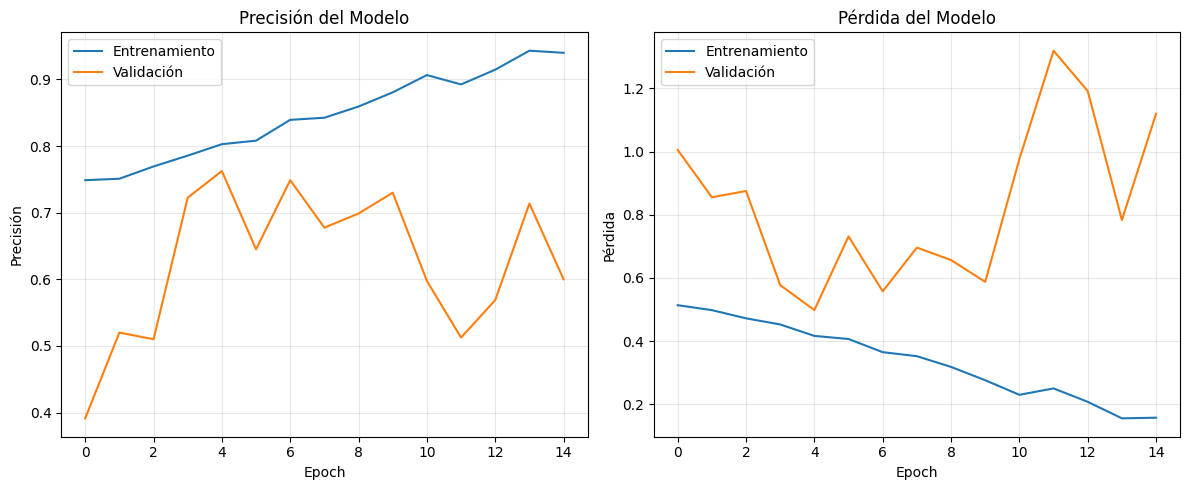

In [55]:
# Visualizar el historial de entrenamiento
plt.figure(figsize=(12, 5))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del Modelo')
plt.xlabel('Epoch')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Epoch')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

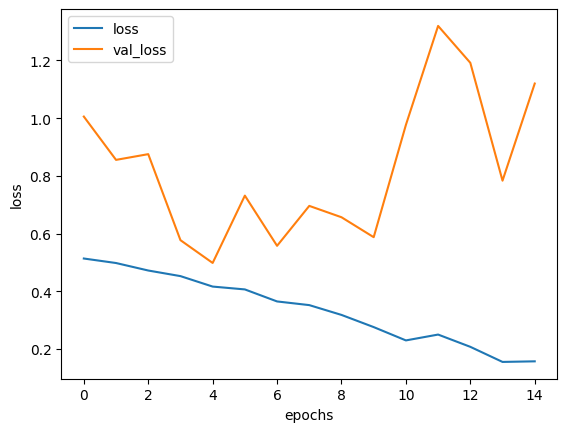

In [49]:
history_df = pd.DataFrame(history.history)
history_df[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

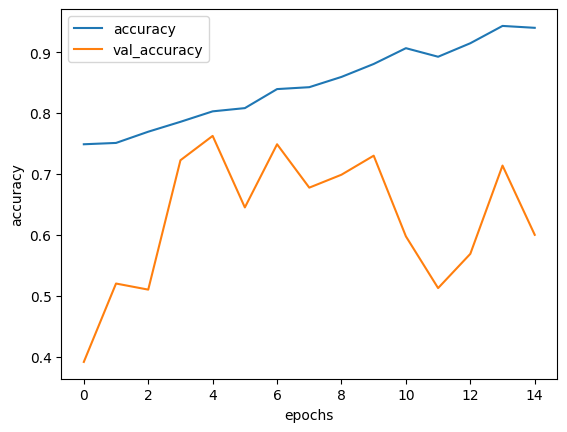

In [50]:
history_df = pd.DataFrame(history.history)
history_df[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

### Evaluación del modelo

In [51]:
model.evaluate(X_test,y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7273 - loss: 0.5233


[0.5099241137504578, 0.7649999856948853]

In [52]:
y_pred = [np.argmax(prediction) for prediction in  model.predict(X_test)]

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [53]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       500
           1       0.00      0.00      0.00       500

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.33      1000



c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f


Evaluando el modelo en el conjunto de prueba...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7273 - loss: 0.5233
Precisión en test: 0.7650
Pérdida en test: 0.5099
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

        Gato       0.80      0.71      0.75       500
       Perro       0.74      0.82      0.78       500

    accuracy                           0.77      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.77      0.77      0.76      1000



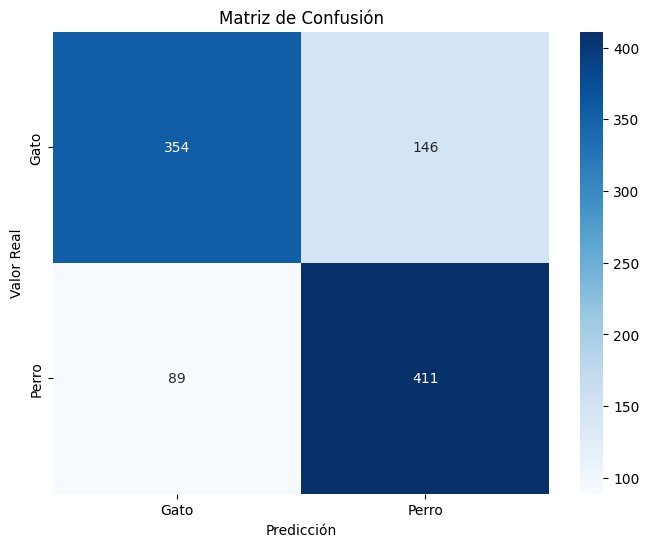

In [60]:
# Evaluar el modelo en los datos de prueba
print("\nEvaluando el modelo en el conjunto de prueba...")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en test: {test_acc:.4f}")
print(f"Pérdida en test: {test_loss:.4f}")

# Hacer predicciones en el conjunto de prueba
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Mostrar el reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['Gato', 'Perro']))

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Gato', 'Perro'], 
            yticklabels=['Gato', 'Perro'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

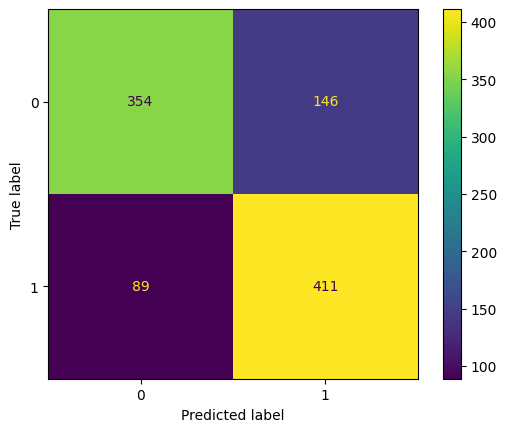

In [58]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Se detectan mejor a los perros (recall más alto), pero confunde más gatos como perros (recall más bajo para gatos).

-  Verdaderos Positivos (411, esquina inferior derecha): El modelo clasificó correctamente 411 imágenes de la clase 1 (perros).
- Verdaderos Negativos (354, esquina superior izquierda): Se identificaron correctamente 354 imágenes de la clase 0 (gatos).
-  Falsos Positivos (146, esquina superior derecha): 146 imágenes de la clase 0 (gatos) fueron clasificadas erróneamente como clase 1 (perros).
- Falsos Negativos (89, esquina inferior izquierda): 89 imágenes de la clase 1 (perros) fueron clasificadas erróneamente como clase 0 (gatos).
> Conclusiones:
-  El modelo tiene más falsos positivos que falsos negativos, lo que significa que tiende a clasificar más gatos como perros que viceversa.
-  La precisión para la clase 1 (perros) es mejor que para la clase 0 (gatos), ya que tiene más verdaderos positivos y menos falsos negativos.

### Seleccion de imagenes mal clasificadas

In [87]:
results_df = pd.DataFrame({
    'filename': test_filenames,
    'true_label': y_test,
    'pred_prob': y_pred_prob.flatten(),
    'pred_label': y_pred,
    'is_correct': y_test == y_pred,
    'misclass' : y_test != y_pred
})

In [88]:
results_df

# rappel label :1-->Perro ; 2-->Gato

,filename,true_label,pred_prob,pred_label,is_correct,misclass
0,cat.10705.jpg,0,0.582928,1,False,True
1,cat.10711.jpg,0,0.373124,0,True,False
2,cat.10714.jpg,0,0.089925,0,True,False
3,cat.10715.jpg,0,0.274129,0,True,False
4,cat.10716.jpg,0,0.766401,1,False,True
...,...,...,...,...,...,...
995,dog.9883.jpg,1,0.733764,1,True,False
996,dog.9884.jpg,1,0.910319,1,True,False
997,dog.9885.jpg,1,0.695231,1,True,False
998,dog.9889.jpg,1,0.746326,1,True,False


In [67]:
malclass= results_df['true_label'] != results_df['predicted_label']

KeyError: 'predicted_label'

In [89]:
misclassified = results_df[results_df['misclass']]

In [90]:
misclassified.is_correct.value_counts()

is_correct
False    235
Name: count, dtype: int64

In [92]:
(len(misclassified)/len(results_df) ) 

0.235

In [93]:
cats_as_dogs = misclassified[misclassified['true_label'] == 0].copy()
dogs_as_cats = misclassified[misclassified['true_label'] == 1].copy()

print(f"Gatos clasificados como perros: {len(cats_as_dogs)}")
print(f"Perros clasificados como gatos: {len(dogs_as_cats)}")

# Para gatos clasificados como perros, el nivel de confianza errónea es pred_prob
# (probabilidad de ser perro cuando es gato)
cats_as_dogs = cats_as_dogs.sort_values('pred_prob', ascending=False)


Gatos clasificados como perros: 146
Perros clasificados como gatos: 89


In [94]:
# Para gatos clasificados como perros, el nivel de confianza errónea es pred_prob
# (probabilidad de ser perro cuando es gato)
cats_as_dogs = cats_as_dogs.sort_values('pred_prob', ascending=False)

In [95]:
len(cats_as_dogs)

146

In [96]:
# Para perros clasificados como gatos, el nivel de confianza errónea es (1 - pred_prob)
# (probabilidad de ser gato cuando es perro)
dogs_as_cats['confidence_wrong_class'] = 1 - dogs_as_cats['pred_prob']
dogs_as_cats = dogs_as_cats.sort_values('confidence_wrong_class', ascending=False)

# Seleccionar el 10% de cada categoría
num_cats_to_select = int(np.ceil(len(cats_as_dogs) * 0.1))
num_dogs_to_select = int(np.ceil(len(dogs_as_cats) * 0.1))

# Seleccionar las imágenes
selected_cats = cats_as_dogs.head(num_cats_to_select)
selected_dogs = dogs_as_cats.head(num_dogs_to_select)

print(f"\nSeleccionadas {len(selected_cats)} imágenes de gatos clasificadas erróneamente como perros")
print(f"Seleccionadas {len(selected_dogs)} imágenes de perros clasificadas erróneamente como gatos")



Seleccionadas 15 imágenes de gatos clasificadas erróneamente como perros
Seleccionadas 9 imágenes de perros clasificadas erróneamente como gatos
